In [31]:
%reload_ext nb_black
import warnings
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline
import os

print(os.getcwd())

print(os.listdir(os.getcwd()))

C:\Users\jlim7\OneDrive\Documents\GitHub\For-Fun-LoL-Data
['.git', '.gitignore', '.ipynb_checkpoints', 'Data Analysis.ipynb', 'high_diamond_ranked_10min.csv', 'Lol Blue Wins Classification.ipynb', 'Lol Data.zip', 'README.md']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
# the data set contains stats 10 min into diamond ranked games (~10k)
# data obtained from https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min
lol = pd.read_csv("high_diamond_ranked_10min.csv")
lol.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


<IPython.core.display.Javascript object>

# EDA

In [4]:
pd.set_option("display.max_columns", None)

<IPython.core.display.Javascript object>

In [19]:
### Drop all red columns, focus solely on blue side.
blue_lol = lol[lol.columns.drop(list(lol.filter(regex="red")))]
blue_lol.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
# Eye balling the data, there are columns that are not necessary and can be dropped
blue_lol = blue_lol.drop(
    columns=[
        "gameId",
        "blueGoldPerMin",
        "blueGoldDiff",
        "blueCSPerMin",
        "blueAvgLevel",
        "blueExperienceDiff",
    ]
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
blue_lol.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled
0,0,28,2,1,9,6,11,0,0,0,0,17210,17039,195,36
1,0,12,1,0,5,5,5,0,0,0,0,14712,16265,174,43
2,0,15,0,0,7,11,4,1,1,0,0,16113,16221,186,46
3,0,43,1,0,4,5,5,1,0,1,0,15157,17954,201,55
4,0,75,4,0,6,6,6,0,0,0,0,16400,18543,210,57


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
blue_lol.shape

(9879, 15)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# There does not appear to be any missing values in the data set.
blue_lol.isna().mean()

blueWins                        0.0
blueWardsPlaced                 0.0
blueWardsDestroyed              0.0
blueFirstBlood                  0.0
blueKills                       0.0
blueDeaths                      0.0
blueAssists                     0.0
blueEliteMonsters               0.0
blueDragons                     0.0
blueHeralds                     0.0
blueTowersDestroyed             0.0
blueTotalGold                   0.0
blueAvgLevel                    0.0
blueTotalExperience             0.0
blueTotalMinionsKilled          0.0
blueTotalJungleMinionsKilled    0.0
blueGoldDiff                    0.0
blueExperienceDiff              0.0
blueCSPerMin                    0.0
blueGoldPerMin                  0.0
dtype: float64

<IPython.core.display.Javascript object>

In [15]:
blue_lol.dtypes

blueWins                          int64
blueWardsPlaced                   int64
blueWardsDestroyed                int64
blueFirstBlood                    int64
blueKills                         int64
blueDeaths                        int64
blueAssists                       int64
blueEliteMonsters                 int64
blueDragons                       int64
blueHeralds                       int64
blueTowersDestroyed               int64
blueTotalGold                     int64
blueAvgLevel                    float64
blueTotalExperience               int64
blueTotalMinionsKilled            int64
blueTotalJungleMinionsKilled      int64
blueGoldDiff                      int64
blueExperienceDiff                int64
blueCSPerMin                    float64
blueGoldPerMin                  float64
dtype: object

<IPython.core.display.Javascript object>

In [10]:
# This will be the target variable (what we are trying to predict)
blue_lol["blueWins"].value_counts()

0    4949
1    4930
Name: blueWins, dtype: int64

<IPython.core.display.Javascript object>

# Random Forest Classifier

In [26]:
X = blue_lol.drop(columns=["blueWins"])
y = blue_lol["blueWins"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=13
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
model.score(X_train, y_train)

1.0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
model.score(X_test, y_test)

0.7064777327935222

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
print_vif(X_train)

VIF results
-------------------------------
const                           791.648048
blueWardsPlaced                   1.012001
blueWardsDestroyed                1.025452
blueFirstBlood                    1.201113
blueKills                        13.394240
blueDeaths                        1.624717
blueAssists                       3.633185
blueEliteMonsters                      inf
blueDragons                            inf
blueHeralds                            inf
blueTowersDestroyed               1.612424
blueTotalGold                    18.089381
blueTotalExperience               4.157650
blueTotalMinionsKilled            3.007973
blueTotalJungleMinionsKilled      1.813111
dtype: float64
-------------------------------



C:\Users\jlim7\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

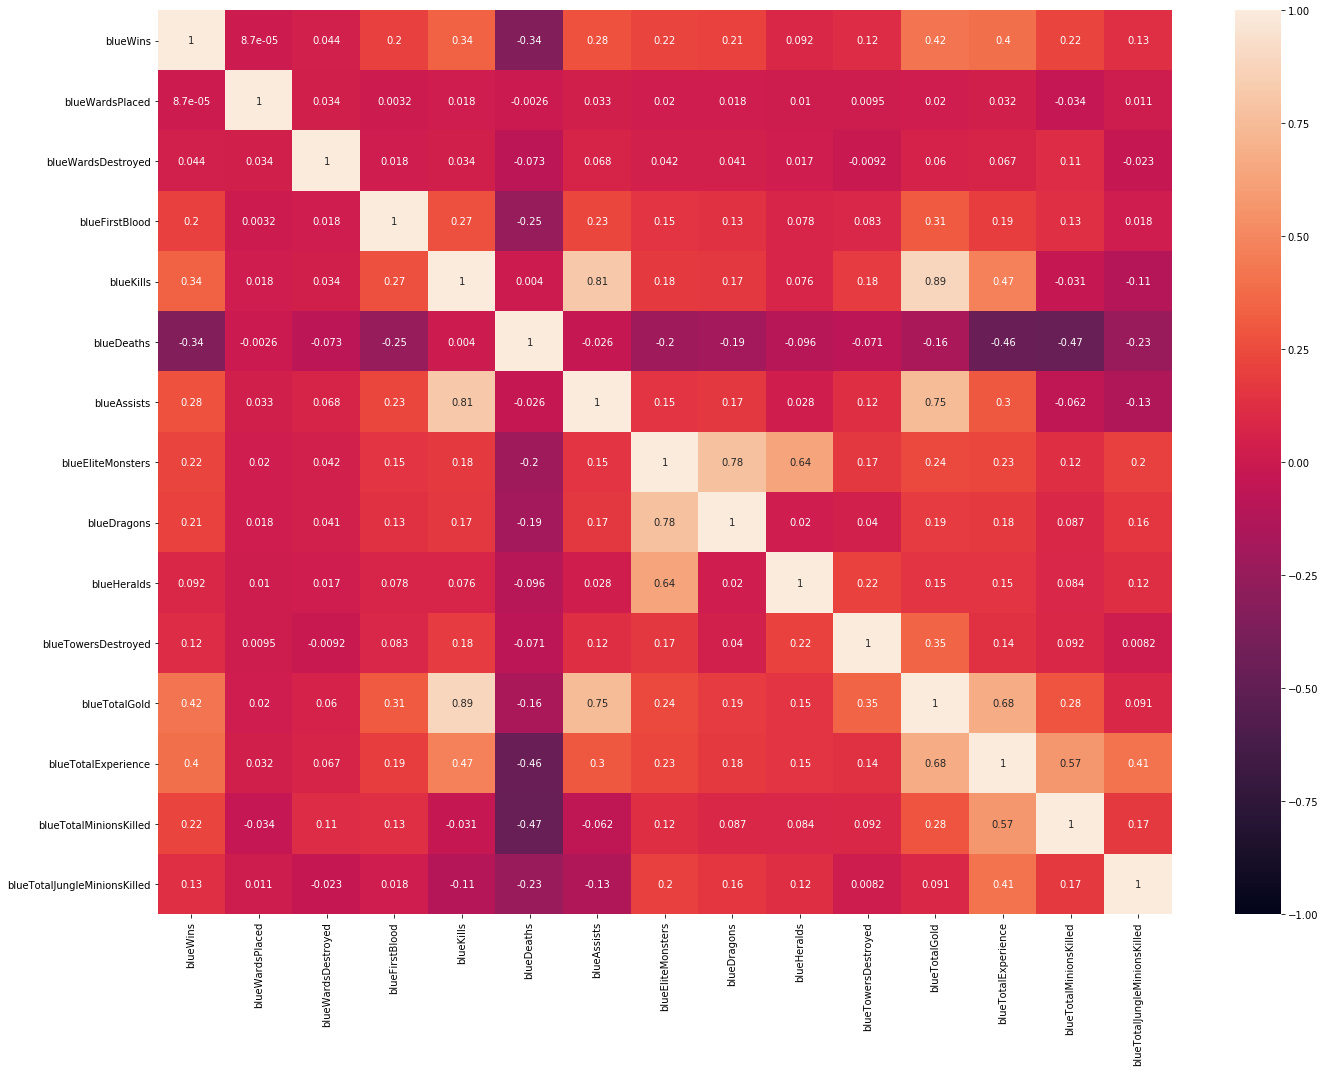

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
plt.figure(figsize=(20, 15))
sns.heatmap(blue_lol.corr(), vmin=-1.0, vmax=1.0, annot=True)
plt.tight_layout()
plt.show()

In [30]:
win = blue_lol[blue_lol["blueWins"] == 1]
lose = blue_lol[blue_lol["blueWins"] == 0]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
win.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin
5,4475365709,1,18,0,0,5,3,6,1,1,...,0,15899,7.0,18161,225,42,698,101,22.5,1589.9
6,4493010632,1,18,3,1,7,6,7,1,1,...,0,16874,6.8,16967,225,53,2411,1563,22.5,1687.4
9,4509433346,1,13,1,1,4,5,5,1,1,...,0,15057,6.8,16805,220,39,-1548,-1574,22.0,1505.7
12,4515594785,1,18,1,1,7,1,11,1,1,...,0,17865,7.4,19102,238,53,3274,1659,23.8,1786.5
14,4516505202,1,15,3,1,4,4,4,0,0,...,0,15722,6.8,17896,224,51,-470,-187,22.4,1572.2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
lose.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0
1,4523371949,0,12,1,0,5,5,5,0,0,...,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

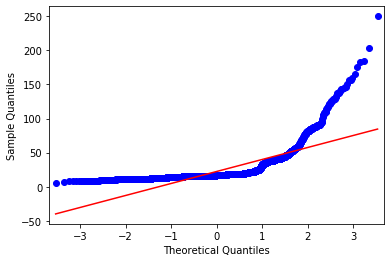

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
qqplot(win["blueWardsPlaced"], line="s")
plt.show()

DescribeResult(nobs=4930, minmax=(5, 250), mean=22.289858012170384, variance=309.67271107742107, skewness=4.287780025136976, kurtosis=25.98049790284806)


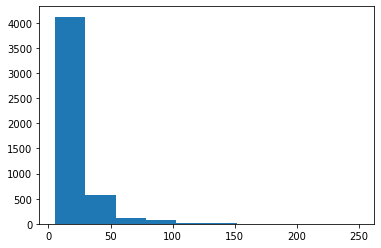

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
plt.hist(win["blueWardsPlaced"])
print(stats.describe(win["blueWardsPlaced"]))

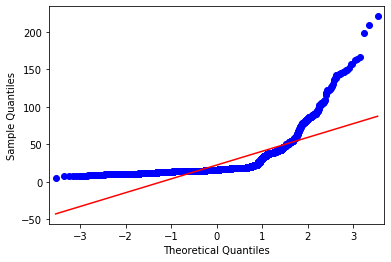

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
qqplot(lose["blueWardsPlaced"], line="s")
plt.show()

DescribeResult(nobs=4930, minmax=(5, 250), mean=22.289858012170384, variance=309.67271107742107, skewness=4.287780025136976, kurtosis=25.98049790284806)


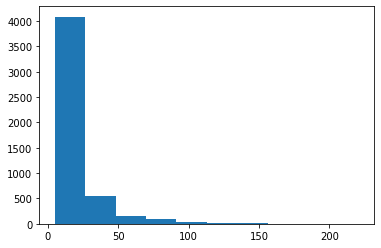

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
plt.hist(lose["blueWardsPlaced"])
print(stats.describe(win["blueWardsPlaced"]))

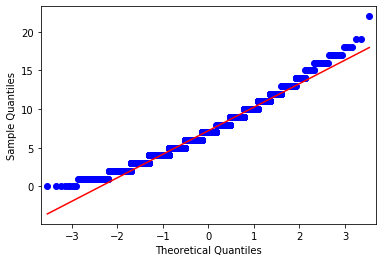

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [64]:
qqplot(win["blueKills"], line="s")
plt.show()

DescribeResult(nobs=4930, minmax=(0, 22), mean=7.201622718052739, variance=9.246822280027507, skewness=0.46422802937133084, kurtosis=0.20930635387141017)


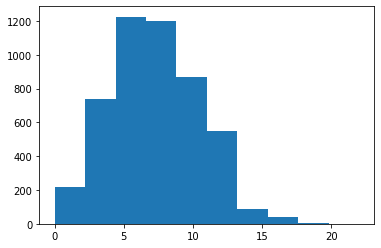

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:
plt.hist(win["blueKills"])
print(stats.describe(win["blueKills"]))

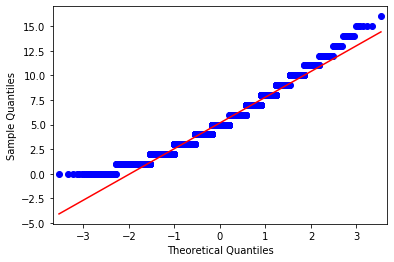

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [66]:
qqplot(lose["blueKills"], line="s")
plt.show()

DescribeResult(nobs=4930, minmax=(0, 22), mean=7.201622718052739, variance=9.246822280027507, skewness=0.46422802937133084, kurtosis=0.20930635387141017)


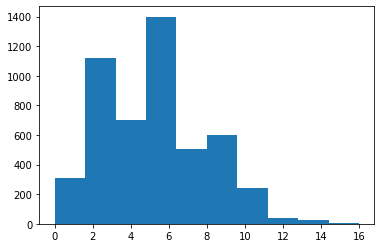

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [67]:
plt.hist(lose["blueKills"])
print(stats.describe(win["blueKills"]))

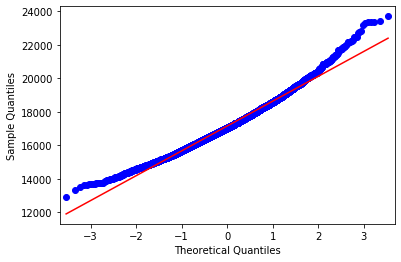

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [69]:
qqplot(win["blueTotalGold"], line="s")
plt.show()

DescribeResult(nobs=4930, minmax=(12939, 23701), mean=17145.263894523327, variance=2200229.052074097, skewness=0.5233637451088191, kurtosis=0.5570391350915829)


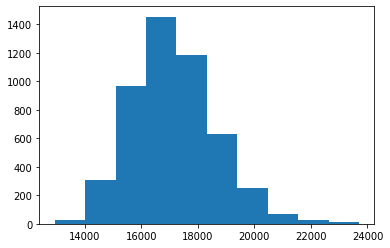

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
plt.hist(win["blueTotalGold"])
print(stats.describe(win["blueTotalGold"]))
plt.show()

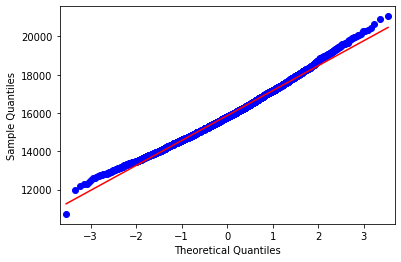

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [72]:
qqplot(lose["blueTotalGold"], line="s")
plt.show()

DescribeResult(nobs=4949, minmax=(10730, 21055), mean=15864.111133562335, variance=1695572.5317050407, skewness=0.3224807443885579, kurtosis=0.1260047656959844)


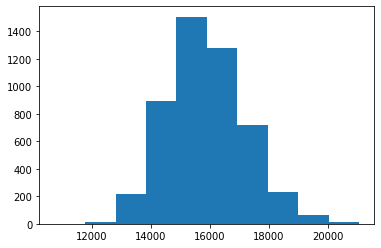

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [73]:
plt.hist(lose["blueTotalGold"])
print(stats.describe(lose["blueTotalGold"]))
plt.show()